In [2]:
## CE 295 - Energy Systems and Control
#   HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
#   Oski Bear, SID 18681868
#   Prof. Moura
#   Last updated: February 25, 2018

# BEAR_OSKI_HW3.ipynb

import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

In [3]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([0,0.2,0,0.4,0.17,0.23,1.155,0,0.17,0.843,0,0.17,0.128])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([0,0.116,0,0.29,0.125,0.132,0.66,0,0.151,0.462,0,0.08,0.086])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([5,0,0,3,0,0,0,0,0,3,0,0,0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([100,0,0,150,0,0,0,0,0,50,0,0,0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([[0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# x_ij: Reactance [p.u.]
x = np.array([[0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([[0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# \rho(j): Parent node of node j
rho = np.array([0,0,1,2,1,4,1,6,6,8,6,10,10]) # you will fill this out!

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.zeros((len(rho),len(rho)))# you will fill this out!
j = 0
for i in rho:
        A[i,j] = 1
        j+=1

### Set Data
# List of node indices
j_idx = np.arange(13)



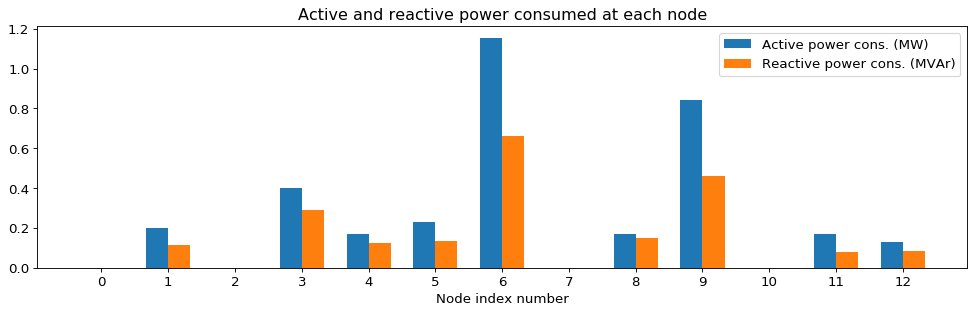

In [4]:
## Problem 1

# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')

#
barWidth = .33
loc_P = np.arange(len(l_P))
loc_Q = loc_P+barWidth

# create plot
plt.rcParams.update({'font.size': 12})

plt.bar(loc_P, l_P, width=barWidth, label="Active power cons. (MW)")
plt.bar(loc_Q, l_Q, width=barWidth, label="Reactive power cons. (MVAr)")
plt.xticks([b + barWidth/2 for b in range(len(j_idx))] ,j_idx)
plt.xlabel("Node index number")
plt.title("Active and reactive power consumed at each node")
plt.legend()
plt.show()

In [5]:
## Problem 2

# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13) #active gen?
q = Variable(13) #reactive gen?
s = Variable(13) #apparent gen? Where's demand? OH--given; we respond to it

# Define objective function
objective = Minimize(sum(multiply(c,s)))

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P), sum(q) == sum(l_Q)]

# Loop over each node ....##why do we have to loop? OK, at each node, this must be true! Cool!
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0, q[jj] >= 0]

    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj]))) <= s[jj]]

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print("------------------- PROBLEM 2 --------------------")
print("--------------------------------------------------")
print(prob2.status)
print("Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [6]:
## Problem 3

# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13) #active gen
q = Variable(13) #reactive gen
s = Variable(13) #apparent gen
P = Variable((13,13)) #active power flowing TO j
Q = Variable((13,13)) #reactive power flowing TO j

# Define objective function
objective = Minimize(c.T*s)

# Define constraints
#Balance power generation with power consumption -- still want this one?
#but maybe it's now like demand at node has to equal power flowing into node? so sep constraint?
#constraints += [np.sum(s) == np.sum(l_S), np.sum(p) == np.sum(l_P), np.sum(q) == np.sum(l_Q)]
#doesn't seem to make a diff

# Apparent Power Limits
constraints = [s <= s_max]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
               Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    # Parent node, i = \rho(j)
    i = rho[jj]
    # Line Power Flows....confused about two versions of P in equation
    constraints += [P[i,jj] == l_P[jj] - p[jj] + sum(multiply(A[jj,:],P[jj,:])),
                    Q[i,jj] == l_Q[jj] - q[jj] + sum(multiply(A[jj,:],Q[jj,:]))]

    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj]))) <= s[jj]]
    
    #still want this one? Seems safe enough
    constraints += [s[jj] >= 0, p[jj] >= 0, q[jj] >= 0]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print("------------------- PROBLEM 3 --------------------")
print("--------------------------------------------------")
print(prob3.status)
print("Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [11]:
## Problem 4

# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13) #active gen
q = Variable(13) #reactive gen
s = Variable(13) #apparent gen
P = Variable((13,13)) #active power flowing TO j
Q = Variable((13,13)) #reactive power flowing TO j
V = Variable(13)
L = Variable((13,13))

# Define objective function
objective = Minimize(c.T*s)

# Define constraints

# Apparent Power Limits
constraints = [s <= s_max]

# Demand matches supply -- not in original
#constraints += [np.sum(s) == np.sum(l_S), np.sum(p) == np.sum(l_P), np.sum(q) == np.sum(l_Q)]

# Nodal voltage limits
constraints += [v_min**2 <= V,
               V <= v_max**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == l_P[jj] - p[jj] + r[i,jj]*L[i,jj] + sum(multiply(A[jj,:],P[jj,:])),
                    Q[i,jj] == l_Q[jj] - q[jj] + x[i,jj]*L[i,jj] + sum(multiply(A[jj,:],Q[jj,:]))]

    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj])), 2) <= s[jj]]
    
    # Positivity constraint -- not in original
    constraints += [s[jj] >= 0, p[jj] >= 0, q[jj] >= 0]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2)*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj])]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(P[i,jj], V[jj]) + quad_over_lin(Q[i,jj], V[jj])]

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 4 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.967 p.u.
Node  2 Voltage : 0.963 p.u.
Node  3 Voltage : 0.963 p.u.
Node  4 Voltage : 0.962 p.u.
Node  5 Voltage : 0.960 p.u.
Node  6 Voltage : 0.957 p.u.
Node  7 Voltage : 0.957 p.u.
Node  8 Voltage : 0.957 p.u.
Node  9 Voltage : 0.964 p.u.
Node 10 Voltage : 0.955 p.u.
Node 11 Voltage : 0.954 p.u.
Node 12

In [8]:
print("For constraint V > v_min:")
for jj in j_idx:
    print("At node %2.0f"%(jj), "the dual variable is %1.3f"%(constraints[1].dual_value[jj]))
print(" ")
print("For constraint V < v_max:")
for jj in j_idx:
    print("At node %2.0f"%(jj), "the dual variable is %1.3f"%(constraints[2].dual_value[jj]))

For constraint V > v_min:
At node  0 the dual variable is 0.000
At node  1 the dual variable is 0.000
At node  2 the dual variable is 0.000
At node  3 the dual variable is 0.000
At node  4 the dual variable is 0.000
At node  5 the dual variable is 0.000
At node  6 the dual variable is 0.000
At node  7 the dual variable is 0.000
At node  8 the dual variable is 0.000
At node  9 the dual variable is 0.000
At node 10 the dual variable is 0.000
At node 11 the dual variable is 0.000
At node 12 the dual variable is 0.000
 
For constraint V < v_max:
At node  0 the dual variable is 0.000
At node  1 the dual variable is 0.000
At node  2 the dual variable is 0.000
At node  3 the dual variable is 0.000
At node  4 the dual variable is 0.000
At node  5 the dual variable is 0.000
At node  6 the dual variable is 0.000
At node  7 the dual variable is 0.000
At node  8 the dual variable is 0.000
At node  9 the dual variable is 0.000
At node 10 the dual variable is 0.000
At node 11 the dual variable is 0.

In [9]:
print("For constraint L < I_max**2:")
for jj in j_idx:
    i = rho[jj]
    print("At node %2.0f"%(jj), "the dual variable is %1.3f"%(constraints[3].dual_value[i,jj]))

For constraint L < I_max**2:
At node  0 the dual variable is 90.963
At node  1 the dual variable is 0.000
At node  2 the dual variable is 0.000
At node  3 the dual variable is 0.000
At node  4 the dual variable is 0.000
At node  5 the dual variable is 0.000
At node  6 the dual variable is 0.000
At node  7 the dual variable is 0.000
At node  8 the dual variable is 0.000
At node  9 the dual variable is 22.518
At node 10 the dual variable is 0.000
At node 11 the dual variable is 0.000
At node 12 the dual variable is 0.000


In [10]:
## Problem 5

# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

